Code which runs the generative model multiple times with different parameters. The model runs once in each cell then below the generative cells we plot the incoherence against the temperture list. The parameters like N and average degree can be odified at the start of the cell for each network.

We also plot the approximation for the Incoherence here as well. Below this the code is mostly other code from the rest of the work which is redundant here. And the other parameters listed here relate to this.

In [1]:
#using LightGraphs, GraphIO, GraphPlot
using Graphs, GraphIO, GraphPlot, SparseArrays


In [2]:
using GraphPlot

In [3]:
#gplot(g, layout=layout=circular_layout)

In [4]:
using LinearAlgebra, IterativeSolvers, Statistics
#Function which calculates Trophic Level

function get_levels(A)
    
    A= convert(Array{Float64}, A)
    
    w_in = vec(sum(A, dims=1))
   
    w_out= vec(sum(A, dims=2))
    
   
    
    u = w_in + w_out 
    
    v= w_in - w_out 
   
    Lambda=  diagm(u)-  A - transpose(A)
    
   
    Lambda[1,1]= 0 
    
    #h= bicgstabl(Lambda, v, 10)
    h=  lsmr(Lambda, v)   
    #h= Lambda \ v   
    h= h .- minimum(h)
    
    return h
end

get_levels (generic function with 1 method)

In [5]:
#Function to calculate Tau as in Looplessness Paper, PNAS, Johnson et al.


function tau(A, F,L,N)
    
    eta_sqaured = F/ (1- F)
    
    expect_term = 0
    
    w_in = vec(sum(A, dims=1))
   
    w_out= vec(sum(A, dims=2))
    
    
    alpha = dot(w_in, w_out)/L
    
    if 0 in w_in
        
        L_B=0
        
        for a in 1:N
            
            if w_in == 0
              L_B = L_B + w_out[a]  
                
            end
        end
        
        
         expect_term = 1/(2*(L/L_B -1))   
            
            
        end 
    
    
    tau = log(alpha)  - 1/(2*eta_sqaured) + expect_term
    
    
    return tau,alpha
    
    end 

tau (generic function with 1 method)

In [6]:
#Function to calculate Trophic Incohrence 

using SparseArrays
function calc_troph_incoh(A)
    
    F=0

    
    A=sparse(A)
    for (x,y,v) in zip(findnz(A)...)
  
    
        F = F + v*(h[y] - h[x] -1 )^2
        
    end
    
    F= F/sum(A)
    
end
    
    
    
    
    

calc_troph_incoh (generic function with 1 method)

In [7]:
using SparseArrays




In [80]:
using LinearAlgebra, Pseudospectra, SparseArrays
using Arpack

#setting up network number and size of network N

const number=1000
ϵ= 10^(-8)
const N=500
sizes = zeros(0)

using Random, Distributions

#d = Normal(0, 0.2)

#Range of T control paramater can be linear or log 

#T_list= LinRange(0.025, 8, number)

T_list= 10 .^ (range(-2,stop=2,length=number))

#T_list= [1000000]
#For N=500, k=10 good temp
#T_list= 0.225*ones(number)
const B=0
#T_list= 0.4*ones(number)
F_list = zeros(0)

strong_list = zeros(0)

clustering_list= zeros(0)

tau_list= zeros(0)
alpha_list =zeros(0)
num_diff_list= zeros(0)
#Controls the number of edges 

L_targ = 20*N
cond_list =zeros(0)
stop= 2*N^2
second_strong_list=zeros(0)
eig_list= zeros(0)
lap_spec_list= zeros(0)
eig_list_num_abs = zeros(0)

h_max_list= zeros(0)

gap_list = zeros(0)
scale_spec_list = zeros(0)
entropy_list=zeros(0)
nu_normal_list= zeros(0)
spacing_list=zeros(0)
ipr_list= zeros(0)
#A= zeros(N,N)
h=zeros(N)
sorted=zeros(0)
corr_list= zeros(0)
diffs= zeros(0)

avg_diffs=zeros(0)
avg_diffs2=zeros(0)
h_eig_list= zeros(0)
max_cycle_list= zeros(0)

h_dist_list= zeros(0)

pseudo_spec= zeros(0)
EE_list= zeros(0)
return_list = zeros(0)

pr_ent_list=zeros(0)
#stop = 5

mean_strong_list=zeros(0)

L_targ_list= zeros(0)

J_max_list= zeros(0)

eig_cent_corr= zeros(0)



for n in 1:number
    
    #Uncomment to vary degrees 
    #L_targ= rand(4:20)*N
    
    #append!(L_targ_list, L_targ)
    println(n)
    spacing= zeros(N)
    
    g = SimpleDiGraph(N)
    
    #Intial Graph to add edges to 

    for i in (1+B):N
        
        pick = rand(B+1:N)
        
        add_edge!(g, pick, i)
        
        
        end 
    A = (adjacency_matrix(g))
    
    L=sum(A)
    
    h = get_levels(A)
    
    
    edgelist= Int[]
    
    problist= zeros(0)
    
    edge_start= zeros(Int64,0)
    
    edge_end = zeros(Int64, 0)
    
    #Calculate Probablities of Adding edges 

    for i in 1:N
        
        for j in (B+1):N
            
            if A[i,j]!=1 && i!=j
                #Fix Array indexing here doesn't make sense. Need 2d array
                append!( edgelist, [i,j] )
                append!( edge_start, i )
                append!(edge_end, j )
                
                prob = exp(-((h[j]-h[i] -1)^2)/T_list[n]/2) + 0.00000000000001
                
                
                
                append!( problist, prob )
            end
            
            
            
            end
        
            end 
    
    prob_sum = sum(problist)
    
    loop_size= size(problist, 1)
    
    
    
    #More Effieciemt sampling of probabilities of edges addition 

        
    count=0
    
    
    while (-L + L_targ)>0
        
        count = count + 1 
        
        prob_sum = sum(problist)
        
        random = prob_sum*(rand())
        
        
        z=0
        
        #println(prob_sum)
        for k in 1:loop_size
            
            z= z + problist[k]
            
           
            if z>=random
               
                if A[edge_start[k],edge_end[k]]==0
                
                   A[edge_start[k],edge_end[k]]=1
                    
                   problist[k]=0 
                
                    L = L +1
                    
                    break
                       
                else 
                    
                    println("Missed")
                   
                    println(A[(edgelist[k])])
                    break
                   
              
                end     
            
            end
                end
            
            if (count-stop)>=0
            
                
                
            
                break
        
            
            
                end
        
    end
        
    
    
    

#Taking data on network using inbuilt functions    
   
    
    
h = get_levels(A)
    
F= calc_troph_incoh(A)    
append!( F_list, F )  
    
end
println(F_list)




1


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [81]:
using Arpack

#setting up network number and size of network N

const number=1000
ϵ= 10^(-8)
const N=100
sizes = zeros(0)

using Random, Distributions

#d = Normal(0, 0.2)

#Range of T control paramater can be linear or log 

#T_list= LinRange(0.025, 8, number)

T_list= 10 .^ (range(-2,stop=2,length=number))

#T_list= [1000000]
#For N=500, k=10 good temp
#T_list= 0.225*ones(number)
const B=0
#T_list= 0.4*ones(number)
F_list_2 = zeros(0)

strong_list = zeros(0)

clustering_list= zeros(0)

tau_list= zeros(0)
alpha_list =zeros(0)
num_diff_list= zeros(0)
#Controls the number of edges 

L_targ = 20*N
cond_list =zeros(0)
stop= 2*N^2
second_strong_list=zeros(0)
eig_list= zeros(0)
lap_spec_list= zeros(0)
eig_list_num_abs = zeros(0)

h_max_list= zeros(0)

gap_list = zeros(0)
scale_spec_list = zeros(0)
entropy_list=zeros(0)
nu_normal_list= zeros(0)
spacing_list=zeros(0)
ipr_list= zeros(0)
#A= zeros(N,N)
h=zeros(N)
sorted=zeros(0)
corr_list= zeros(0)
diffs= zeros(0)

avg_diffs=zeros(0)
avg_diffs2=zeros(0)
h_eig_list= zeros(0)
max_cycle_list= zeros(0)

h_dist_list= zeros(0)

pseudo_spec= zeros(0)
EE_list= zeros(0)
return_list = zeros(0)

pr_ent_list=zeros(0)
#stop = 5

mean_strong_list=zeros(0)

L_targ_list= zeros(0)

J_max_list= zeros(0)

eig_cent_corr= zeros(0)



for n in 1:number
    
    #Uncomment to vary degrees 
    #L_targ= rand(4:20)*N
    
    #append!(L_targ_list, L_targ)
    println(n)
    spacing= zeros(N)
    
    g = SimpleDiGraph(N)
    
    #Intial Graph to add edges to 

    for i in (1+B):N
        
        pick = rand(B+1:N)
        
        add_edge!(g, pick, i)
        
        
        end 
    A = (adjacency_matrix(g))
    
    L=sum(A)
    
    h = get_levels(A)
    
    
    edgelist= Int[]
    
    problist= zeros(0)
    
    edge_start= zeros(Int64,0)
    
    edge_end = zeros(Int64, 0)
    
    #Calculate Probablities of Adding edges 

    for i in 1:N
        
        for j in (B+1):N
            
            if A[i,j]!=1 && i!=j
                #Fix Array indexing here doesn't make sense. Need 2d array
                append!( edgelist, [i,j] )
                append!( edge_start, i )
                append!(edge_end, j )
                
                prob = exp(-((h[j]-h[i] -1)^2)/T_list[n]/2) + 0.00000000000001
                
                
                
                append!( problist, prob )
            end
            
            
            
            end
        
            end 
    
    prob_sum = sum(problist)
    
    loop_size= size(problist, 1)
    
    
    
    #More Effieciemt sampling of probabilities of edges addition 

        
    count=0
    
    
    while (-L + L_targ)>0
        
        count = count + 1 
        
        prob_sum = sum(problist)
        
        random = prob_sum*(rand())
        
        
        z=0
        
        #println(prob_sum)
        for k in 1:loop_size
            
            z= z + problist[k]
            
           
            if z>=random
               
                if A[edge_start[k],edge_end[k]]==0
                
                   A[edge_start[k],edge_end[k]]=1
                    
                   problist[k]=0 
                
                    L = L +1
                    
                    break
                       
                else 
                    
                    println("Missed")
                   
                    println(A[(edgelist[k])])
                    break
                   
              
                end     
            
            end
                end
            
            if (count-stop)>=0
            
                
                
            
                break
        
            
            
                end
        
    end
        
    
    
    

#Taking data on network using inbuilt functions    
   
    
    
h = get_levels(A)
    
F= calc_troph_incoh(A)    
append!( F_list_2, F )  
    
end
println(F_list_2)

1
2
3


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
27

[0.10877540324161226, 0.1210076792468802, 0.341688355401343, 0.12160354900412265, 0.11280318691427904, 0.10841770898956526, 0.11862999634239581, 0.11531518892461659, 0.09578005920745314, 0.09133018706515533, 0.11584170413221453, 0.09876829343502332, 0.11770041486259035, 0.09977297865594731, 0.167713591651028, 0.12665154626798228, 0.13180620710482707, 0.14647384522574794, 0.09461437824796884, 0.10266422565076067, 0.11772311982070616, 0.10749803396439765, 0.11534271131491061, 0.08581078978653389, 0.0910096917460023, 0.12186113314890294, 0.08999462936677477, 0.15215010777736632, 0.11797488770336675, 0.11932016968453925, 0.13468590411760878, 0.1280750120432195, 0.10713993257406275, 0.1437080311891562, 0.13623898468799958, 0.10587302669045905, 0.10444395232817272, 0.17848452565239273, 0.09777728424183346, 0.1302933810516321, 0.12720482731325816, 0.1330203321318067, 0.13237509626355098, 0.1257585541984929, 0.06103818185450354, 0.10749403455122687, 0.10234002713504811, 0.169031681545439, 0.09

In [82]:
using Arpack

#setting up network number and size of network N

const number=1000
ϵ= 10^(-8)
const N=200
sizes = zeros(0)

using Random, Distributions

#d = Normal(0, 0.2)

#Range of T control paramater can be linear or log 

#T_list= LinRange(0.025, 8, number)

T_list= 10 .^ (range(-2,stop=2,length=number))

#T_list= [1000000]
#For N=500, k=10 good temp
#T_list= 0.225*ones(number)
const B=0
#T_list= 0.4*ones(number)
F_list_3 = zeros(0)

strong_list = zeros(0)

clustering_list= zeros(0)

tau_list= zeros(0)
alpha_list =zeros(0)
num_diff_list= zeros(0)
#Controls the number of edges 

L_targ = 20*N
cond_list =zeros(0)
stop= 2*N^2
second_strong_list=zeros(0)
eig_list= zeros(0)
lap_spec_list= zeros(0)
eig_list_num_abs = zeros(0)

h_max_list= zeros(0)

gap_list = zeros(0)
scale_spec_list = zeros(0)
entropy_list=zeros(0)
nu_normal_list= zeros(0)
spacing_list=zeros(0)
ipr_list= zeros(0)
#A= zeros(N,N)
h=zeros(N)
sorted=zeros(0)
corr_list= zeros(0)
diffs= zeros(0)

avg_diffs=zeros(0)
avg_diffs2=zeros(0)
h_eig_list= zeros(0)
max_cycle_list= zeros(0)

h_dist_list= zeros(0)

pseudo_spec= zeros(0)
EE_list= zeros(0)
return_list = zeros(0)

pr_ent_list=zeros(0)
#stop = 5

mean_strong_list=zeros(0)

L_targ_list= zeros(0)

J_max_list= zeros(0)

eig_cent_corr= zeros(0)



for n in 1:number
    
    #Uncomment to vary degrees 
    #L_targ= rand(4:20)*N
    
    #append!(L_targ_list, L_targ)
    println(n)
    spacing= zeros(N)
    
    g = SimpleDiGraph(N)
    
    #Intial Graph to add edges to 

    for i in (1+B):N
        
        pick = rand(B+1:N)
        
        add_edge!(g, pick, i)
        
        
        end 
    A = (adjacency_matrix(g))
    
    L=sum(A)
    
    h = get_levels(A)
    
    
    edgelist= Int[]
    
    problist= zeros(0)
    
    edge_start= zeros(Int64,0)
    
    edge_end = zeros(Int64, 0)
    
    #Calculate Probablities of Adding edges 

    for i in 1:N
        
        for j in (B+1):N
            
            if A[i,j]!=1 && i!=j
                #Fix Array indexing here doesn't make sense. Need 2d array
                append!( edgelist, [i,j] )
                append!( edge_start, i )
                append!(edge_end, j )
                
                prob = exp(-((h[j]-h[i] -1)^2)/T_list[n]/2) + 0.00000000000001
                
                
                
                append!( problist, prob )
            end
            
            
            
            end
        
            end 
    
    prob_sum = sum(problist)
    
    loop_size= size(problist, 1)
    
    
    
    #More Effieciemt sampling of probabilities of edges addition 

        
    count=0
    
    
    while (-L + L_targ)>0
        
        count = count + 1 
        
        prob_sum = sum(problist)
        
        random = prob_sum*(rand())
        
        
        z=0
        
        #println(prob_sum)
        for k in 1:loop_size
            
            z= z + problist[k]
            
           
            if z>=random
               
                if A[edge_start[k],edge_end[k]]==0
                
                   A[edge_start[k],edge_end[k]]=1
                    
                   problist[k]=0 
                
                    L = L +1
                    
                    break
                       
                else 
                    
                    println("Missed")
                   
                    println(A[(edgelist[k])])
                    break
                   
              
                end     
            
            end
                end
            
            if (count-stop)>=0
            
                
                
            
                break
        
            
            
                end
        
    end
        
    
    
    

#Taking data on network using inbuilt functions    
   
    
    
h = get_levels(A)
    
F= calc_troph_incoh(A)    
append!( F_list_3, F )  
    
end
println(F_list_3)

1


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

Plotting all the data gathered. Details of data type included in figure captions

In [83]:
using Plots

#histogram(diffs, xlabel= "Level Differences", ylabel="Frequency", title=(string("N=1000 k=10 F=",  string(round(F,digits = 3) ))))

#savefig("Generated_Level_distribution_high.pdf")

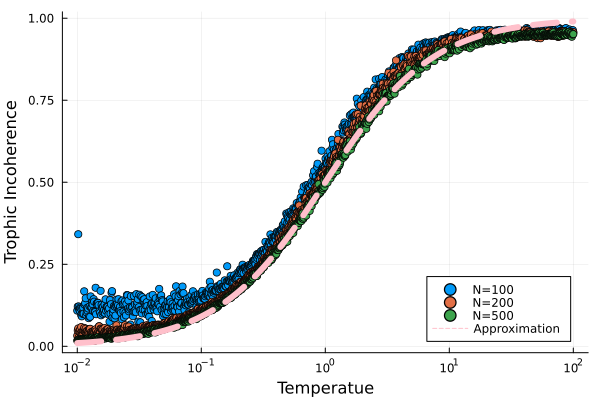

In [103]:
using Plots


plot(T_list,F_list_2, seriestype = :scatter,  xlabel= "Temperatue",

ylabel="Trophic Incoherence",  label= "N=100")


plot!(T_list,F_list_3, seriestype = :scatter, legend = true, xlabel= "Temperatue",

ylabel="Trophic Incoherence",  label= "N=200")


plot!(T_list,F_list, seriestype = :scatter,  xlabel= "Temperatue",

ylabel="Trophic Incoherence",  label= "N=500")




T_line= 10 .^ (range(-2,stop=2,length=5000))

plot!(T_line,(T_line)./(T_line .+ 1), legend = :bottomright, xlabel= "Temperatue",

ylabel="Trophic Incoherence",   label= "Approximation", lw=6, xaxis=:log, ls=:dash, color=:pink)




#savefig("Working_approximation__no_log_1000_points.pdf")

In [13]:

using Polynomials, SpecialFunctions

x=F_list

y= num_diff_list


plot(F_list, num_diff_list, seriestype = :scatter, legend = :topleft, xlabel= "Trophic Incoherence",

ylabel="Fraction of Negative Edges", title= "Fraction of Negative Edges", label= "Networks")



F_plot= LinRange(0, 1, 1000)


arg= - sqrt.(-F_plot .+1)./(F_plot*(2)) 

erf_function= 0.5*(1 .+ erf.(arg))

plot!(F_plot,  erf_function , label= "ERF Approx", lw=3)

#quadfit=Polynomials.fit(x,y,1)
#plot!(quadfit,x[1],x[end],label="Linear Fit", lw = 3)

#savefig("Error_function_approx_negative_edges_generated.pdf")


DivideError: DivideError: integer division error

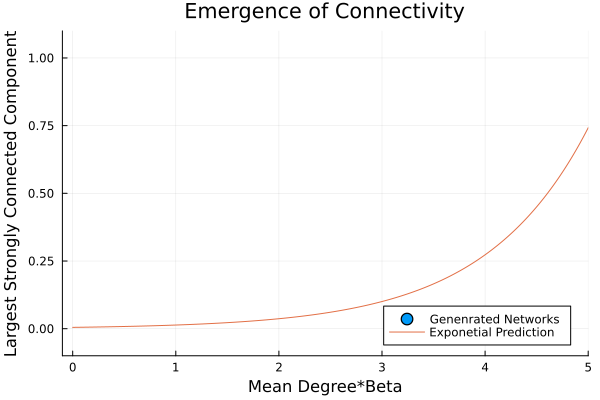

In [14]:
#plot(( -num_diff_list.^-1 .+ L_targ/N) , mean_strong_list/N,legend=false,seriestype = :scatter,ylabel="Mean Strongly Connected Component", xlabel="Mean Degree - 1/Beta",title="Emergence of Connectivity")

#plot(( num_diff_list*L_targ/N ) , mean_strong_list/N,legend=false,seriestype = :scatter,ylabel="Mean Strongly Connected Component", xlabel="Mean Degree*Beta",title="Emergence of Connectivity")


F_plot= LinRange(0, 10, 1000)


#F_plot= LinRange(0.000001, 10, 1000)

plot(( num_diff_list*L_targ/N ) , strong_list,legend=:bottomright,seriestype = :scatter,ylabel="Largest Strongly Connected Component", xlabel="Mean Degree*Beta",title="Emergence of Connectivity" ,label="Genenrated Networks")

#plot!(sign.(F_plot), F_plot .-5, ylim=(-0.1,1.1), linestyle=:dash, label="Critical Point") 
plot!(F_plot, exp.(F_plot)/N, ylim=(-0.1,1.1),xlim=(-0.1,5), label="Exponetial Prediction") 
    
    
#savefig("EXP_undershoots_Connectivity_Generated_Degree_Beta_N_100.pdf")

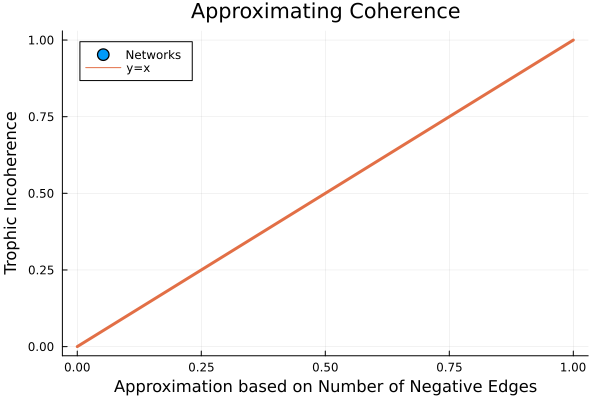

In [15]:
y= F_list

#x = 2*num_diff_list.*avg_diffs .- avg_diffs .+ 1

x =   -avg_diffs2  .+1

line= LinRange(0, 1, 1000)

plot(line,line)

plot(x, y, seriestype = :scatter, legend = legend = :topleft, ylabel= "Trophic Incoherence",

xlabel="Approximation based on Number of Negative Edges", title= "Approximating Coherence", label= "Networks")


plot!(line,line, label="y=x", lw = 3)



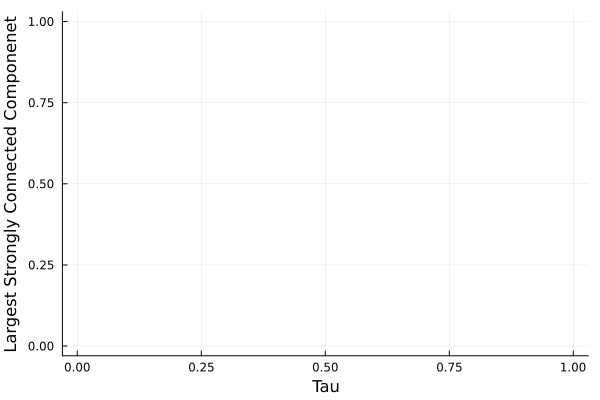

In [16]:
plot((tau_list), strong_list, seriestype = :scatter, legend=:false, ylabel="Largest Strongly Connected Componenet"

,xlabel= "Tau")
#println(strong_list)
#savefig("tau_largest_strong_component.pdf")

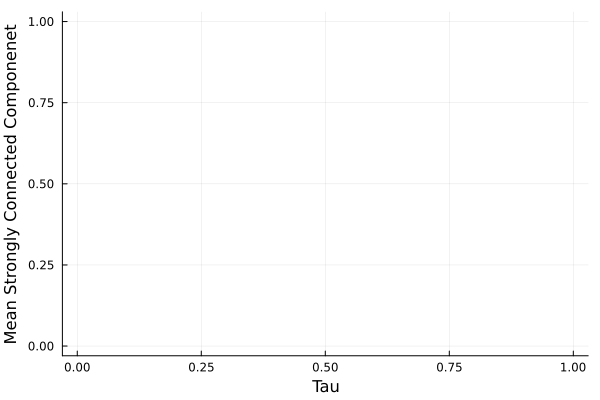

In [17]:
plot((tau_list), mean_strong_list, seriestype = :scatter, legend=:false, ylabel="Mean Strongly Connected Componenet"

,xlabel= "Tau")


#savefig("tau_mean_strong_component.pdf")

In [18]:
using StatsBase


using LaTeXStrings

F_round= round(mean(F_list),digits=3 )

tau_round= round(mean(tau_list),digits=3 )

#histogram(x , normalize = true, seriestype = :scatter,  yaxis=:log, xaxis=:log )

#using StatsBase, Plots
#hist = (StatsBase.fit(Histogram, x))
#Plots.plot((hist))

d = countmap(sizes)
#println( pweights(x))

x = collect(keys(d))/N

y= collect(values(d))/N/number

Plots.plot(log10.(x), log10.(y) , seriestype=:scatter,legend=false , label="Networks Generated",
    

ylabel= "No. of Stongly connected Componenets", xlabel="Size of Strongly Connected Component", title =" Mean F= $F_round Mean tau = $tau_round")

#line= LinRange(0.1, 1, 1000)

#quadfit=Polynomials.fit((x),(y),1)
#plot!(quadfit,x[1],x[end],label="Linear Fit", lw = 3, xlim=(1/N -0.1*(1/N) ,1.1),xaxis=:log,yaxis=:log )

using CurveFit


p = sortperm(x)

#print(x)

x = x[p]

y=  y[p]

x= x[2:30]

y=y[2:30]

a,b = linear_fit(log10.(x), log10.(y))


println(a,b)
xlim=(1/N -0.1*(1/N),1.1)

ylim= (0.0001,1)

b_round= round(b,digits=3)

plot!(log10.(line), log10.(line)*b .+a, label="Linear Fit exponent $b_round", lw = 3 , legend=true)


#savefig("GRS3_Strong_distrubution__low_tau_test_very_dependent_on_size_Tau.pdf")

LoadError: BoundsError: attempt to access 0-element Vector{Float64} at index [2:30]

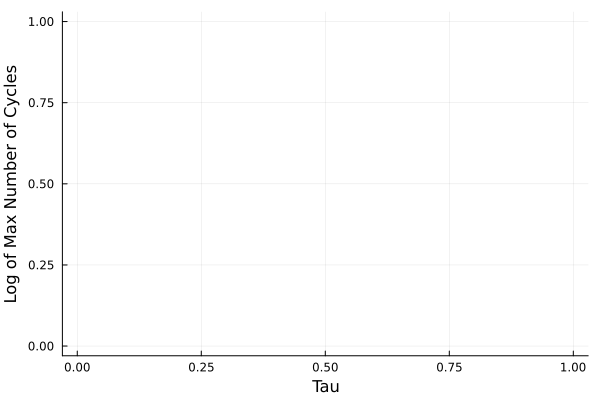

In [19]:
plot(tau_list, log10.(max_cycle_list),seriestype = :scatter,legend=false, xlabel="Tau", ylabel="Log of Max Number of Cycles")


#savefig("N_30_cycles_tau.pdf")

In [20]:
plot(F_list.^-1,log.(alpha_list), seriestype = :scatter, legend=false, ylabel="Log of Alpha", xlabel="1/F")

#savefig("Log_alpha_versus_1_over_F.pdf")

DivideError: DivideError: integer division error

In [21]:
#println(eig_list)

plot(F_list, eig_list, seriestype = :scatter, legend = :bottomright, xlabel= "Trophic Incoherence",

ylabel="Abscissa of Networks", title= "Spectral Properties", label= "Spectral" )

plot!(F_list, eig_list_num_abs, seriestype = :scatter, label = "Numerical")
#savefig("Abscissa_of_Networks.pdf")

DivideError: DivideError: integer division error

In [22]:
plot(F_list, eig_list_num_abs -eig_list , seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Numerical
Radius Minus Spectral Radius", title= "Measures of Non-Normality")
#savefig("Other_Non_normality_measure_Networks.pdf")

DivideError: DivideError: integer division error

In [23]:
#plot(F_list, (cond_list), seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",
    #ylabel="Conidtion Number" , yaxis=:log)

#savefig("Condition_number_N_500.png")

In [24]:
plot(F_list, h_max_list, seriestype = :scatter, legend = false, xlabel= "Tau",

ylabel="Maximum Trophic Level with min at zero", title= "Level Distrubution", label= "Spectral" )

#savefig("tau_Maximum_Level_Numerical_Networks.pdf")



DivideError: DivideError: integer division error

In [25]:
plot(F_list, scale_spec_list, seriestype = :scatter, legend = :bottomright, xlabel= "Trophic Incoherence",

ylabel="Scaled Spectral Radius", title= "Spectral Properties", label= "Networks Generated" )

F_plot= LinRange(0, 1, 1000)

plot!(F_plot,  exp.(((1 .- 1 ./ F_plot))/2), label= "exp((1 - 1/F)/2)", lw=3)

#savefig("scaled_spec_radius_test.pdf")

DivideError: DivideError: integer division error

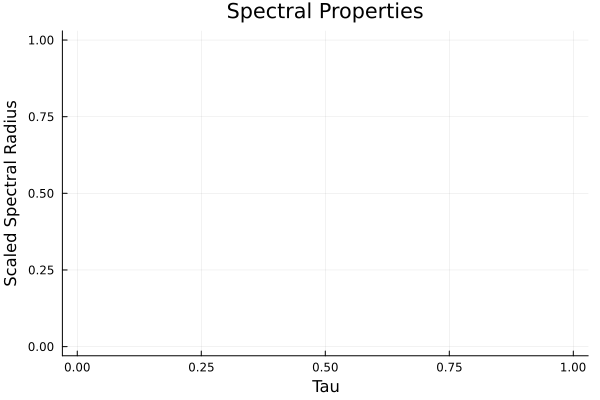

In [26]:
plot((tau_list), scale_spec_list, seriestype = :scatter,  xlabel= "Tau",

ylabel="Scaled Spectral Radius", title= "Spectral Properties", label= "Networks Generated" ,legend=:false )

#F_plot= LinRange(0, 1, 1000)

#plot!(F_plot,  exp.(((1 .- 1 ./ F_plot))/2), label= "exp((1 - 1/F)/2)", lw=3)

#savefig("sign_tau_scaled_spec_radius.pdf")

In [27]:
plot(F_list, nu_normal_list, seriestype = :scatter, legend = :bottomright, xlabel= "Trophic Incoherence",

ylabel="Normality, nu", title= "Normality", label= "Networks Generated" )



plot!(F_plot,  exp.(((1 .- 1 ./ F_plot))), label= "exp((1 - 1/F))", lw=3)

#savefig("nu_normlity_test_dense.pdf")

DivideError: DivideError: integer division error

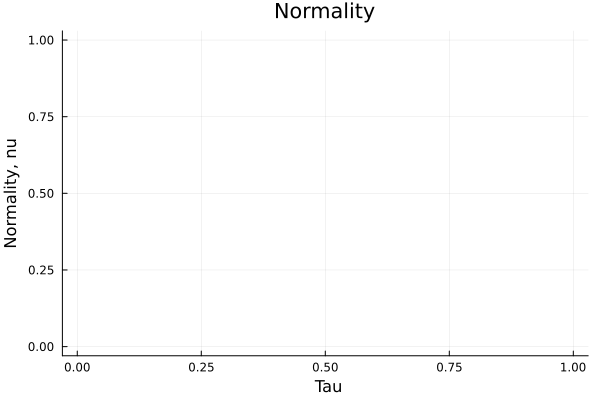

In [28]:
plot((tau_list), nu_normal_list, seriestype = :scatter, legend = :false, xlabel= " Tau",

ylabel="Normality, nu", title= "Normality", label= "Networks Generated" )



#plot!(F_plot,  exp.(((1 .- 1 ./ F_plot))), label= "exp((1 - 1/F))", lw=3)

#savefig("normality_tau_sign.pdf")

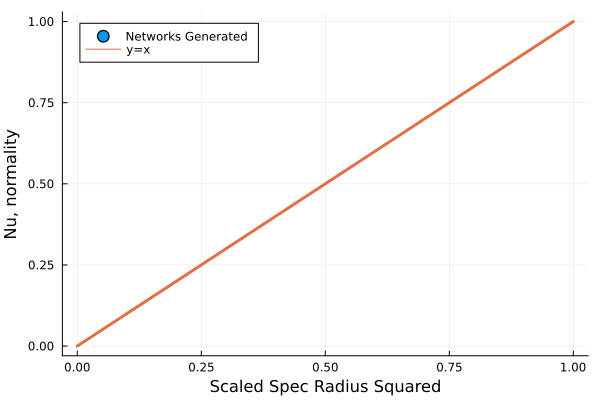

In [29]:
plot(scale_spec_list.^2 , nu_normal_list, seriestype = :scatter, label= "Networks Generated", legend = :topleft, xlabel="Scaled Spec Radius Squared"

,ylabel = "Nu, normality")

plot!(line,line, label="y=x", lw = 3)

#savefig("nu_normlity_analysis_dense.pdf")

In [30]:
plot(F_list, lap_spec_list, seriestype = :scatter, legend=:false, xlabel="Trophic Incoherence", ylabel = "Spectral Radius of Laplacian Matrix", title ="Total-degree Lapalcian")


#savefig("total_lapacian_test.pdf")

DivideError: DivideError: integer division error

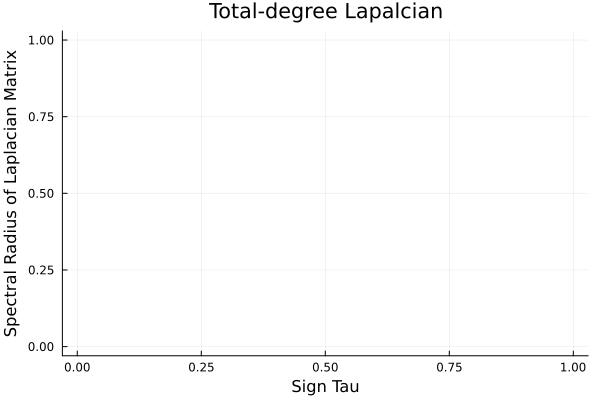

In [31]:
plot((tau_list), lap_spec_list, seriestype = :scatter, legend=:false, xlabel="Sign Tau", ylabel = "Spectral Radius of Laplacian Matrix", title ="Total-degree Lapalcian")


#savefig("sign_tau_total_lapacian_test.pdf")


In [32]:
plot(F_list, J_max_list, seriestype = :scatter, xlims = (0,1) ,legend=:false, xlabel="Trophic Incoherence", ylabel="Largest Real Eigenvalue of Modified W")
#savefig("Modified_W.pdf")

DivideError: DivideError: integer division error

In [33]:
pseudo_spec

plot(F_list, pseudo_spec, seriestype = :scatter, legend = :false, xlabel= "Trophic Incoherence",

ylabel="Pseudo Spectral Radius", )


DivideError: DivideError: integer division error

In [34]:


using LaTeXStrings

plot(F_list, ((pseudo_spec -eig_list)/ϵ), seriestype = :scatter, legend = :false, xlabel= "Trophic Incoherence",

ylabel=L" \frac {\rho_\epsilon(A) - \rho(A)}{\epsilon} " ,yaxis=:log )


#savefig("Pseduo_spec_data.pdf")

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/niallrodgers/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/niallrodgers/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191


DivideError: DivideError: integer division error

In [35]:
using LaTeXStrings

plot(tau_list, ((pseudo_spec -eig_list)/ϵ), seriestype = :scatter, legend = :false, xlabel= "Tau",

ylabel=L" \frac {\rho_\epsilon(A) - \rho(A)}{\epsilon} " ,yaxis=:log )


#savefig("Tau_Pseduo_spec_data.pdf")

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/niallrodgers/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/niallrodgers/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191


In [36]:
plot((tau_list), entropy_list/maximum(entropy_list), seriestype = :scatter,legend=false ,xlabel= "Tau",

ylabel="Average Eigenvector Entropy",title="Eigenvector Localisation")

#savefig("Log_Tau_Entropy_Eigenvector_localisation.pdf")

LoadError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [37]:
plot(F_list, entropy_list/maximum(entropy_list), seriestype = :scatter,legend=false ,xlabel= "Trophic Incoherence",

ylabel="Average Eigenvector Entropy",title="Eigenvector Localisation")

#savefig("Inlfleunce_paper_good_Entropy_Eigenvector_localisation_N500.pdf")

LoadError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

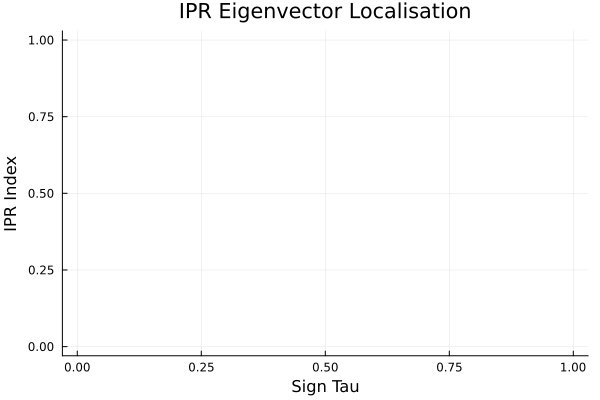

In [38]:
plot((tau_list), (ipr_list), seriestype = :scatter,legend=false ,xlabel= "Sign Tau",

ylabel="IPR Index",title="IPR Eigenvector Localisation" )

#savefig("Log_Tau_IPR_localisation_IPR.pdf")

In [39]:
plot(F_list, (ipr_list), seriestype = :scatter,legend=false ,xlabel= "Trophic Incoherence" , ylabel ="IPR Index")

#savefig("Influence_paper_good_IPR_localisation_IPR_500.pdf")

DivideError: DivideError: integer division error

In [40]:
plot((F_list), eig_cent_corr, seriestype = :scatter,legend=false ,xlabel= "Trophic Incoherence",

ylabel="Correlation of Left and Right Eigenvector" )

#savefig("Influence_good_centrality_corrleation_Gen_n500.pdf")

DivideError: DivideError: integer division error

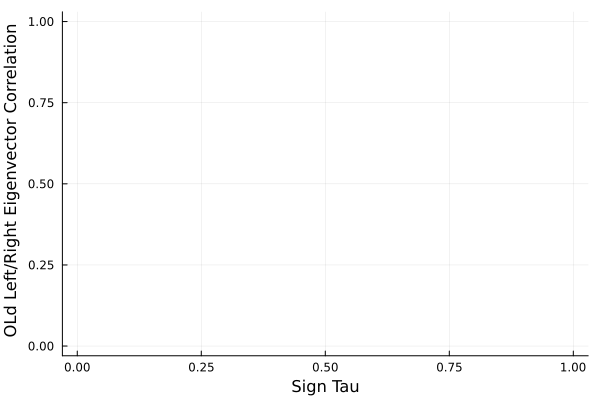

In [41]:
plot((tau_list), corr_list, seriestype = :scatter,legend=false ,xlabel= "Sign Tau",

ylabel=" OLd Left/Right Eigenvector Correlation" )



#savefig("Log_Tau_Eigenvector_corrleation_1.pdf")

In [42]:
plot(F_list, gap_list, seriestype = :scatter,legend=false ,xlabel= "Trophic Incoherence",

ylabel=" Spectral Gap")

#savefig("Spectral_Gap_N_500_scaled_new.png")

DivideError: DivideError: integer division error

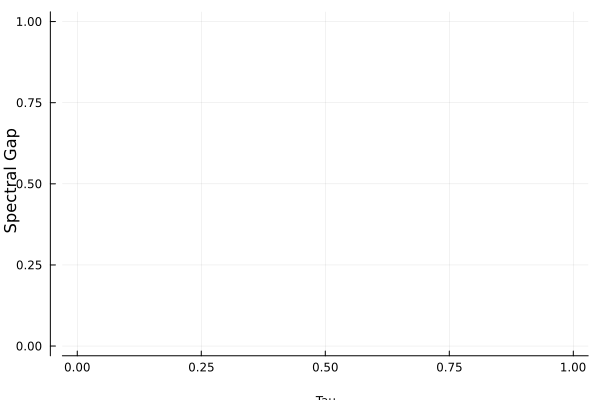

attempt to save state beyond implementation limit


In [43]:
plot((tau_list), gap_list, seriestype = :scatter,legend=false ,xlabel= "Tau",

ylabel=" Spectral Gap")

#savefig("Sign_Tau_Spectral_Gap_N_500_scaled_new.pdf")

In [44]:
#plot(h_dist_list,h_eig_list , seriestype = :scatter,legend=false ,xlabel= "Trophic Level of Node scaled by max level",

#ylabel="  Principle Eigenvector of Node", title= "High Incoherence F approx 0.95")

#savefig("Principle_eigenvector_levels_high_incoherence.png")




In [45]:
plot(F_list, EE_list/N, seriestype = :scatter,legend=false ,xlabel= "Trophic Incoherence",

ylabel=" Estrada Index", yaxis=:log)

#savefig("EE_Index_log_N_500.png")

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/niallrodgers/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/niallrodgers/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191


DivideError: DivideError: integer division error

In [46]:
plot((tau_list), EE_list/N, seriestype = :scatter,legend=false ,xlabel= "Sign Tau ",

ylabel=" Estrada Index",yaxis=:log)

#savefig("Sign_Tau_Estrada_Index.pdf")

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/niallrodgers/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/niallrodgers/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191
attempt to save state beyond implementation limit


In [47]:
plot(F_list, return_list, seriestype = :scatter,legend=false ,xlabel= "Trophic Incoherence",

ylabel=" Returnablity based on Estrada Index", yaxis=:log)

#savefig("Returnablity_index_N500_k_10.pdf")

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/niallrodgers/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/niallrodgers/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191


DivideError: DivideError: integer division error

In [48]:
plot(sign.(tau_list), return_list, seriestype = :scatter,legend=false ,xlabel= "Tau List",

ylabel=" Returnablity based on Estrada Index", yaxis=:log)

#savefig("Sign_Tau_Returnablity_index.pdf")

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/niallrodgers/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/niallrodgers/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191
attempt to save state beyond implementation limit


In [49]:
plot(F_list, spacing_list, seriestype = :scatter,legend=false ,xlabel= "Trophic Incoherence",

ylabel="Varaince of Complex Spacing Ratio")

#savefig("Varaince_Spacing_ratio_spacing_ratio.pdf")

DivideError: DivideError: integer division error

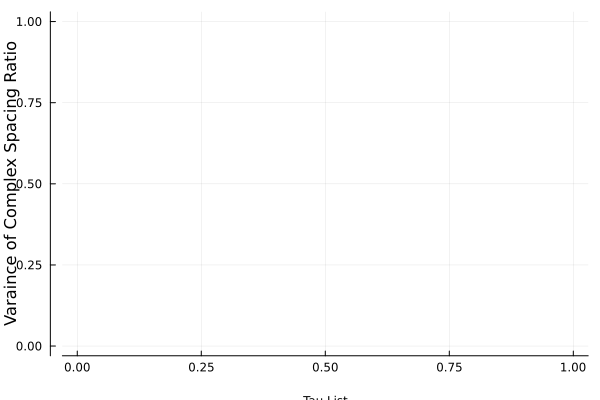

attempt to save state beyond implementation limit


In [50]:
plot(tau_list, spacing_list, seriestype = :scatter,legend=false ,xlabel= "Tau List",

ylabel="Varaince of Complex Spacing Ratio"  )

#savefig("Tau_Varaince_Spacing_ratio_spacing_ratio.pdf")

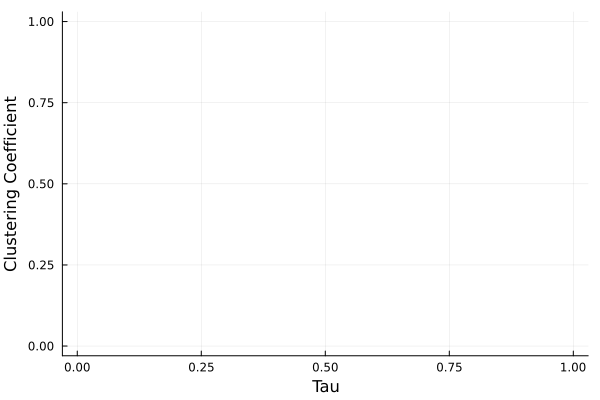

In [51]:
plot(tau_list, clustering_list,seriestype = :scatter, ylabel="Clustering Coefficient" ,xlabel="Tau",legend=false)


#savefig("Clustering_coefficent_tau.pdf")

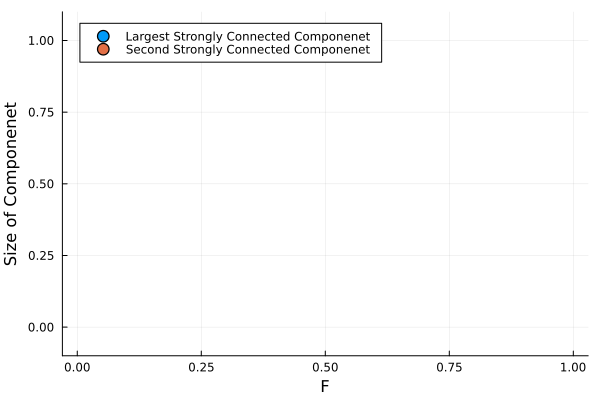

In [52]:
plot(tau_list, strong_list, seriestype = :scatter, label="Largest Strongly Connected Componenet",legend=:topleft,ylim=(-0.1,1.1))

plot!(tau_list, second_strong_list, seriestype = :scatter, label="Second Strongly Connected Componenet", xlabel="F", ylabel="Size of Componenet")

#savefig("Second_largest_component_generated_tau_N_500.pdf")


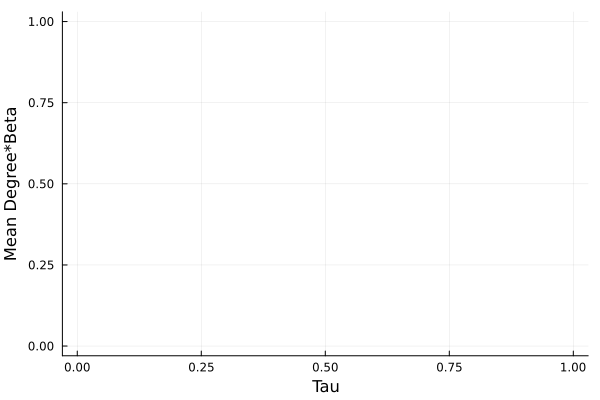

In [53]:
plot(tau_list, ( num_diff_list*L_targ/N) , seriestype = :scatter, xlabel="Tau", ylabel="Mean Degree*Beta", label=false)

#savefig("generated_mean_degree_tau.pdf")

In [54]:
x_plot= LinRange(2, 100, 1000)


L_s= zeros(0)

L_w = zeros(0)

F_s =  zeros(0)

F_w =zeros(0)


for a in 1:(size(F_list)[1])
    
    
    if strong_list[a]>0.9
    
    #append!(L_s, L_targ_list[a]/N)
    append!(L_s, L_targ/N)
    append!(F_s, F_list[a])
        
    
        else 
        
        
        
        #append!(L_w, L_targ_list[a]/N)
        append!(L_w, L_targ/N)
        append!(F_w, F_list[a])
    end
    end 


plot(x_plot,  (1 .+ 2*((erfinv.(2*((x_plot).^-1) .-1)).^2)).^-1,lw=4, label="Prediction of Critical F", color="black", ylabel="Trophic Incoherence", xlabel="Mean Total Degree")


plot!(L_w,F_w, seriestype = :scatter, label="Weakly Connected Networks",color="red")
plot!(L_s,F_s, seriestype = :scatter, label="Strongly Connected Networks", color="blue",  legendfontsize=6, legend=:bottomright)
#savefig("Critical_F_connectivty_artificial_2.pdf")

LoadError: BoundsError: attempt to access 0-element Vector{Float64} at index [1]

In [55]:


plot(F_list, pr_ent_list, seriestype = :scatter, xlabel="Trophic Incoherence", ylabel="Entropy of PageRank",label=false)

#savefig("PageRank_Entropy_test_2.pdf")


DivideError: DivideError: integer division error

In [56]:
g= path_digraph(5)

{5, 4} directed simple Int64 graph

In [57]:
A = (adjacency_matrix(g))

print(A)

sparse([1, 2, 3, 4], [2, 3, 4, 5], [1, 1, 1, 1], 5, 5)